In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
from torch import cdist
import os


In [2]:
from catboost import CatBoostRegressor
from hmmlearn import hmm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import NearestNeighbors
import math
# from statsmodels.tsa.arima.model import ARIMA

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

In [5]:
from processors import processor_factory

In [80]:
case_id_col = "Identification No."
timestamp_col = "Time (hrs)"
work_day_col = "Working Day (d)"
target_col = "Product Content pre clean up (g/L)"

In [7]:
cols_to_keep = [case_id_col, timestamp_col, target_col, work_day_col, 'BR Temp (°C)', 'pH (Internal)', 'Viability (%)', 'VCD (10^6 cells/mL)', 
                'Glutamine (mmol/L)', 'Glutamate (mmol/L)', 'Glucose (g/L)','Lactate (g/L)', 'NH4+ (mmol/L)', 
                'Na+ (mmol/L)', 'K+ (mmol/L)', 'Ca2+ (g/L)']

features = ['BR Temp (°C)', 'pH (Internal)', 'Viability (%)', 'VCD (10^6 cells/mL)', 
                'Glutamine (g/L)', 'Glutamate (g/L)', 'Glucose (g/L)','Lactate (g/L)', 'NH4+ (g/L)', 
                'Na+ (g/L)', 'K+ (g/L)', 'Ca2+ (g/L)']

In [8]:
df_normalized = pd.read_csv('data/processed/CSL312_preprocessed_forTiter_normalised_6Feb25.csv')

In [9]:
len(features)

12

In [10]:
UIDs = df_normalized[case_id_col].unique()

In [186]:

# Assuming your data is stored in a DataFrame called 'data'
average_max_work_day = data.groupby(case_id_col)[work_day_col].max().mean()

print("Average Maximum work_day_col:", average_max_work_day)

Average Maximum work_day_col: 12.335616438356164


In [185]:
len(UIDs)

146

In [83]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

In [12]:
dataset_name = 'CSL312'

In [13]:
# from data.dataset_confs import dataset_configs

# config = dataset_configs['CSL_5L']
use_encoding = False
use_bucketing = False
num_nearest_neighbors = 100
distance_metric = 'euclidean'

# processor = CSL_5LProcessor("5L", use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)
processor = processor_factory.get_processor('CSL312', use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)

AMBR
CSL312
Astrazeneca
bpic2011_f1
bpic2011_f2
bpic2011_f3
bpic2011_f4


In [138]:
# Define the values to experiment with
num_nearest_neighbors_values = [200]
distance_metrics = ['chebyshev']

# Loop through the values and create processors
for num_nearest_neighbors in num_nearest_neighbors_values:
    for distance_metric in distance_metrics:
        print(f"Experimenting with num_nearest_neighbors={num_nearest_neighbors} and distance_metric={distance_metric}")
        
        # Create the processor with the current values
        processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)
        
    

        data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
        data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
        # data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
        data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
        # data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

        historic, current = processor.split_data(data, train_ratio=0.5, split="temporal sim")
        historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
        current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

        if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
            features_used = features + ['Cluster']
        else:
            features_used = features

        # n_neighbors = 200
        # # Initialize the NearestNeighbors model
        # nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
        # # Fit the model on the historic data
        # nn_model.fit(historic[features_used])

        batch_size = 50

        nn_model = processor.train_nn_model(historic[features_used])

        for start in range(0, len(current), batch_size):
            end = start + batch_size
            batch = current.iloc[start:end]
            # Find the n nearest neighbors for the selected row
            # distances, indices = nn_model.kneighbors([row[features_used]])
            distances, indices = processor.find_nearest_neighbors(nn_model, batch[features_used])
            nearest_neighbors = pd.concat([historic.iloc[indices[i]] for i in range(len(batch))])

            target = nearest_neighbors['Target'].values
            target_test = batch['Target']

            if target_test is None:
                continue
            

            if method == 'Catboost':
                # Create the CatBoostRegressor model
                model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
                model.fit(nearest_neighbors[features_used], target)

            if method == 'HMM':
                # Create an instance of the HMM model
                model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
                model.fit(nearest_neighbors[features_used])

            # Make predictions on the testing data
            preds = model.predict(batch[features_used])

            # true_conc_glu = row['Target_orig']
            # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

            batch.loc[:, 'predicted_value'] = preds

            results.append(batch)

            # Add the current row with its prediction to the historic data
            # row_with_prediction[target_col] = preds_scaled[0][0]
            historic = pd.concat([historic, batch], ignore_index=True)
            historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
            nn_model =processor.train_nn_model(historic[features_used])  # Refit the model with the updated historic data

        results_df = pd.concat(results)
        results = []

        # Calculate metrics
        true_values = results_df[target_col]
        predicted_values = results_df['predicted_value']

        MAE_t = mean_absolute_error(true_values, predicted_values)
        MSE_t = mean_squared_error(true_values, predicted_values)
        RMSE_t = math.sqrt(MSE_t)
        r2_t = r2_score(true_values, predicted_values)
        mape_t = mean_absolute_percentage_error(true_values, predicted_values)

        # Save results to a CSV file
        # results_df.to_csv('predictions_with_row_data.csv', index=False)

        # Print metrics
        print(f"MAE: {MAE_t}")
        print(f"MSE: {MSE_t}")
        print(f"RMSE: {RMSE_t}")
        print(f"R2: {r2_t}")
        print(f"MAPE: {mape_t}")

        results_df.to_csv(f'results/{dataset_name}/CSL312_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)
        print('***********************************')


Experimenting with num_nearest_neighbors=200 and distance_metric=chebyshev
int64
MAE: 0.28800419738467253
MSE: 0.1882852996036683
RMSE: 0.433918540285695
R2: 0.8140711031503532
MAPE: 2.123016405682084
***********************************


In [14]:
tmp = pd.read_csv(f'results/{dataset_name}/CSL312_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv')

In [21]:
tmp.tail(959)[case_id_col].unique()

array(['X5217_A4', '410103_200L', '410203_200L', '410204_200L',
       '410205_200L', '410206_200L', 'X4543_A1', 'X4543_A2', 'X4543_B1',
       'X4543_B4', 'X4565_A4', 'X4565_B1', 'X4565_B2', 'X4565_B3',
       'X4581_C1', 'X4581_C3', 'X4581_D1', 'X4582_B1', 'X4582_B2',
       'X4583_A1', 'X4583_A2', 'X4583_A3', 'X4583_B2', 'X5074_E3',
       'X5074_E4', 'X5074_F2', 'X5074_F4', 'X5106_C2', 'X5106_D3',
       'X5112_E2', 'X5112_E3', 'X5112_E4', 'X5112_F1', 'X5123_E3',
       'X5123_E4', 'X5123_F1', 'X5123_F3', 'X5123_F4', 'X5138_F1',
       'X5138_F2', 'X5138_F3', 'X5138_F4', 'X5139_F1', 'X5140_MTS1',
       'X5141_MTS1', 'X5141_MTS2', 'X5184_C1', 'X5184_C3', 'X5184_D2',
       'X5185_E4', 'X5185_F2', 'X5185_F3', 'X5187_C1', 'X5187_C2',
       'X5187_D2', 'X5187_D3', 'X5187_D4', 'X5188_C2', 'X5188_D1',
       'X5188_D4', 'X5189_E3', 'X5189_F1', 'X5189_F3', 'X5189_F4',
       'X5205_A3', 'X5205_A4', 'X5217_A1', 'X5217_A2', 'X5217_A3',
       'X5217_B1', 'X5217_B2', 'X5217_B3', 'X5217_B4'

In [22]:
test_ids = tmp.tail(959)[case_id_col].unique()

In [42]:
test_ids = ['410102_200L', '410103_200L', '410201_200L', '410204_200L',
       '410206_200L', 'X4543_A1', 'X4543_B3', 'X4565_A2', 'X4565_A3',
       'X4565_A4', 'X4565_B4', 'X4580_D4', 'X4581_C2', 'X4582_A1',
       'X4582_B1', 'X4582_B4', 'X4583_A1', 'X4583_A2', 'X4583_A4',
       'X4583_B1', 'X4583_B2', 'X5074_E2', 'X5074_E3', 'X5074_F2',
       'X5074_F4', 'X5106_C1', 'X5106_D1', 'X5112_E1', 'X5112_E3',
       'X5112_F1', 'X5112_F2', 'X5112_F3', 'X5123_E4', 'X5123_F1',
       'X5123_F2', 'X5123_F4', 'X5138_F3', 'X5138_F4', 'X5139_F2',
       'X5139_F3', 'X5139_F4', 'X5140_MTS1', 'X5141_MTS1', 'X5184_C2',
       'X5184_D1', 'X5184_D2', 'X5185_E1', 'X5185_E2', 'X5185_E3',
       'X5185_F1', 'X5185_F2', 'X5187_C2', 'X5187_C3', 'X5187_C4',
       'X5187_D1', 'X5187_D4', 'X5188_C1', 'X5188_C4', 'X5188_D4',
       'X5189_E2', 'X5189_E4', 'X5189_F3', 'X5205_A1', 'X5205_A3',
       'X5205_A4', 'X5205_B1', 'X5205_B3', 'X5217_A1', 'X5217_A2',
       'X5217_A3', 'X5217_A4', 'X5217_B1', 'X5217_B2']

In [137]:
####### Baseline Version without JITL ########

# Define the values to experiment with
results = []

# Create the processor with the current values
processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)



data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = processor.split_data(data, train_ratio=0.5, split="lmo", leave_out=test_ids)
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

target = historic['Target'].values
# target_test = row['Target']

if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.7, depth=6, loss_function='MAE', verbose=0)
        model.fit(historic[features_used], target)

if method == 'HMM':
    # Create an instance of the HMM model
    model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
    model.fit(historic[features_used])

batch_size = 50

for start in range(0, len(current), batch_size):
    end = start + batch_size
    batch = current.iloc[start:end]

    target = historic['Target'].values
    target_test = batch['Target']

    if target_test is None:
        continue

    # Make predictions on the testing data
    preds = model.predict(batch[features_used])

    # true_conc_glu = row['Target_orig']
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

    batch.loc[:, 'predicted_value'] = preds

    results.append(batch)


baseline_results = pd.concat(results)

# Calculate metrics
true_values = baseline_results[target_col]
predicted_values = baseline_results['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

# results_df.to_csv(f'results/{dataset_name}/baseline_CSL312_{method}_{config}.csv', index=False)
print('***********************************')


int64
Train ids: ['410104_200L', '410202_200L', '410203_200L', '410205_200L', 'X4543_A2', 'X4543_A3', 'X4543_A4', 'X4543_B1', 'X4543_B2', 'X4543_B4', 'X4565_A1', 'X4565_B1', 'X4565_B2', 'X4565_B3', 'X4581_C1', 'X4581_C3', 'X4581_C4', 'X4581_D1', 'X4581_D2', 'X4582_A2', 'X4582_A3', 'X4582_A4', 'X4582_B2', 'X4582_B3', 'X4583_A3', 'X4583_B3', 'X4583_B4', 'X5074_E1', 'X5074_E4', 'X5074_F1', 'X5074_F3', 'X5106_C2', 'X5106_C3', 'X5106_C4', 'X5106_D2', 'X5106_D3', 'X5106_D4', 'X5112_E2', 'X5112_E4', 'X5112_F4', 'X5123_E1', 'X5123_E2', 'X5123_E3', 'X5123_F3', 'X5138_F1', 'X5138_F2', 'X5139_F1', 'X5140_MTS2', 'X5141_MTS2', 'X5184_C1', 'X5184_C3', 'X5184_C4', 'X5185_E4', 'X5185_F3', 'X5185_F4', 'X5187_C1', 'X5187_D2', 'X5187_D3', 'X5188_C2', 'X5188_C3', 'X5188_D1', 'X5188_D2', 'X5188_D3', 'X5189_E1', 'X5189_E3', 'X5189_F1', 'X5189_F2', 'X5189_F4', 'X5205_A2', 'X5205_B2', 'X5205_B4', 'X5217_B3', 'X5217_B4']
MAE: 0.3309619461507857
MSE: 0.2493261449260249
RMSE: 0.4993256902323622
R2: 0.75762416734

In [26]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

In [73]:
# Function to calculate MAE
def calculate_mae(df, target_col, predicted_col):
    return np.mean(np.abs(df[target_col] - df[predicted_col]))

# List to store MAE values and corresponding file names
mae_list = []

results_folder = 'results/CSL312'  # Replace with the path to your results folder
target_col = "Target"
# target_col = "Product Content pre clean up (g/L)"

# Get the list of files in the results folder
files = os.scandir(results_folder)


# Loop through each file
for file in files:
    if not file.name.startswith('.') and file.is_file():
        df = pd.read_csv(file.path)
        df = df.tail(722)
        
        # Calculate the MAE for the file
        mae = calculate_mae(df, target_col, 'predicted_value')
        
        # Append the MAE and file name to the list
        mae_list.append((mae, file.name))

mae_list.sort(key=lambda x: x[0])

# Extract the top 4 file names with the lowest MAE
top_4_files = [file_name for _, file_name in mae_list[:4]]

In [74]:
top_4_files

['CSL312_Catboost_no_encoding_no_bucketing_200_chebyshev.csv',
 'CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv',
 'CSL312_Catboost_no_encoding_no_bucketing_400_euclidean.csv',
 'CSL312_Catboost_no_encoding_no_bucketing_400_cosine.csv']

In [58]:
top_4_files = ['CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv',
    'CSL312_Catboost_no_encoding_no_bucketing_300_euclidean.csv',
    'CSL312_Catboost_no_encoding_no_bucketing_300_chebyshev.csv',
    'CSL312_Catboost_no_encoding_no_bucketing_400_euclidean.csv']

In [76]:
# Mapping of filenames to desired labels
filename_to_label = {
    # 'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv': 'Chebyshev with 400 neighbors',
    # 'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    # 'Astra_Catboost_no_encoding_no_bucketing_400_euclidean.csv': 'Euclidean with 400 neighbors',
    # 'Astra_Catboost_no_encoding_no_bucketing_300_cosine.csv': 'Cosine with 300 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_euclidean.csv' : 'Euclidean with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_chebyshev.csv': 'Chebyshev with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv': 'Chebyshev with 400 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_300_euclidean.csv': 'Euclidean with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_300_chebyshev.csv': 'Chebyshev with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_400_euclidean.csv': 'Euclidean with 400 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_200_chebyshev.csv': 'Chebyshev with 200 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_400_cosine.csv': 'Cosine with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_400_chebyshev.csv' : 'Chebyshev with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_300_chebyshev.csv' : 'Chebyshev with 300 neighbors',
    'New_Catboost_no_encoding_no_bucketing_400_euclidean.csv' : 'Euclidean with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_200_chebyshev.csv': 'Chebyshev with 200 neighbors',
    # Add more mappings as needed
}

In [54]:
baseline_results.sort_values([case_id_col, timestamp_col])

,Identification No.,Time (hrs),Product Content pre clean up (g/L),Working Day (d),BR Temp (°C),pH (Internal),Viability (%),VCD (10^6 cells/mL),Glucose (g/L),Lactate (g/L),Ca2+ (g/L),Glutamine (g/L),Glutamate (g/L),Na+ (g/L),K+ (g/L),NH4+ (g/L),Cluster,Titer (g/L) original,Target,predicted_value
0,410102_200L,0.75,-1.087131,0,1.056810,1.327097,0.537907,-1.635679,1.621778,-1.195156,-0.007709,-0.793751,0.313125,0.585203,-2.197873,-1.826047,0,1.110223e-16,-1.042176,-1.030631
1,410102_200L,22.28,-1.042176,1,1.031827,1.327097,0.558432,-1.557811,1.406825,-0.994354,-0.007709,-0.793751,0.374743,0.690240,-2.211087,-1.476049,0,3.374260e-02,-1.003795,-1.092130
2,410102_200L,46.08,-1.003795,2,1.031827,-0.012148,0.650795,-1.352296,0.659161,-0.426871,-0.007709,-0.344009,0.297720,0.752027,-2.164839,-0.795498,0,6.255150e-02,-0.926388,-0.777461
3,410102_200L,69.65,-0.926388,3,1.031827,-1.351394,0.650795,-0.968536,-0.153923,0.062037,-0.006285,0.426978,0.328529,0.677883,-2.170124,0.001719,1,1.206529e-01,-0.775909,-0.654013
4,410102_200L,93.63,-0.775909,4,1.021833,-1.649004,0.671320,-0.469905,-1.275418,0.044576,-0.002012,0.459102,0.058951,1.023889,-2.162196,0.643381,1,2.336012e-01,-0.523386,-0.627655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,X5217_B2,188.68,0.817821,8,-1.016806,0.037454,0.250557,0.845576,-0.854857,-0.103842,-0.034769,-0.119138,-0.903830,0.220661,0.627260,-0.251057,2,1.429845e+00,1.280156,1.285571
1916,X5217_B2,214.53,1.280156,9,-1.016806,0.285462,0.106881,0.881177,0.565703,-0.339566,-0.033345,-0.761627,-1.050173,0.214482,0.729007,-0.445501,2,1.776870e+00,1.539478,1.625722
1917,X5217_B2,237.87,1.539478,10,-0.966839,0.186259,-0.385720,0.792200,-0.677287,-0.444332,-0.034769,-0.793751,-1.050173,0.189767,0.777898,-0.377445,2,1.971516e+00,1.680519,1.600191
1918,X5217_B2,262.82,1.680519,11,-0.966839,0.682276,-0.980947,0.712586,0.621778,-0.409410,-0.033345,-0.793751,-1.050173,-0.156239,0.664259,-0.416334,2,2.077380e+00,1.868611,1.807129


In [55]:
df.sort_values([case_id_col, timestamp_col])

,Identification No.,Time (hrs),Product Content pre clean up (g/L),Working Day (d),BR Temp (°C),pH (Internal),Viability (%),VCD (10^6 cells/mL),Glucose (g/L),Lactate (g/L),Ca2+ (g/L),Glutamine (g/L),Glutamate (g/L),Na+ (g/L),K+ (g/L),NH4+ (g/L),Cluster,Titer (g/L) original,Target,predicted_value
0,410102_200L,0.75,-1.087131,0,1.056810,1.327097,0.537907,-1.635679,1.621778,-1.195156,-0.007709,-0.793751,0.313125,0.585203,-2.197873,-1.826047,0,1.110223e-16,-1.042176,-1.026827
1,410102_200L,22.28,-1.042176,1,1.031827,1.327097,0.558432,-1.557811,1.406825,-0.994354,-0.007709,-0.793751,0.374743,0.690240,-2.211087,-1.476049,0,3.374260e-02,-1.003795,-0.985388
2,410102_200L,46.08,-1.003795,2,1.031827,-0.012148,0.650795,-1.352296,0.659161,-0.426871,-0.007709,-0.344009,0.297720,0.752027,-2.164839,-0.795498,0,6.255150e-02,-0.926388,-0.822688
3,410102_200L,69.65,-0.926388,3,1.031827,-1.351394,0.650795,-0.968536,-0.153923,0.062037,-0.006285,0.426978,0.328529,0.677883,-2.170124,0.001719,1,1.206529e-01,-0.775909,-0.723198
4,410102_200L,93.63,-0.775909,4,1.021833,-1.649004,0.671320,-0.469905,-1.275418,0.044576,-0.002012,0.459102,0.058951,1.023889,-2.162196,0.643381,1,2.336012e-01,-0.523386,-0.604582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,X5217_B2,188.68,0.817821,8,-1.016806,0.037454,0.250557,0.845576,-0.854857,-0.103842,-0.034769,-0.119138,-0.903830,0.220661,0.627260,-0.251057,2,1.429845e+00,1.280156,1.270849
959,X5217_B2,214.53,1.280156,9,-1.016806,0.285462,0.106881,0.881177,0.565703,-0.339566,-0.033345,-0.761627,-1.050173,0.214482,0.729007,-0.445501,2,1.776870e+00,1.539478,1.575755
960,X5217_B2,237.87,1.539478,10,-0.966839,0.186259,-0.385720,0.792200,-0.677287,-0.444332,-0.034769,-0.793751,-1.050173,0.189767,0.777898,-0.377445,2,1.971516e+00,1.680519,1.628979
961,X5217_B2,262.82,1.680519,11,-0.966839,0.682276,-0.980947,0.712586,0.621778,-0.409410,-0.033345,-0.793751,-1.050173,-0.156239,0.664259,-0.416334,2,2.077380e+00,1.868611,1.813238


In [ ]:
baseline_results

In [62]:
cosine100 = pd.read_csv('results/CSL312/CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv')

In [63]:
cosine100.sort_values([case_id_col, timestamp_col])

,Identification No.,Time (hrs),Product Content pre clean up (g/L),Working Day (d),BR Temp (°C),pH (Internal),Viability (%),VCD (10^6 cells/mL),Glucose (g/L),Lactate (g/L),Ca2+ (g/L),Glutamine (g/L),Glutamate (g/L),Na+ (g/L),K+ (g/L),NH4+ (g/L),Cluster,Titer (g/L) original,Target,predicted_value
0,410203_200L,1.50,-1.087095,0,1.036823,1.327097,0.743158,-1.612007,1.061031,-1.195156,-0.021951,-0.793751,0.274614,-2.016022,0.315412,-1.174662,0,0.000027,-1.087070,-1.083681
1,410203_200L,21.93,-1.087070,1,1.041820,1.327097,0.620008,-1.501896,0.836731,-0.915780,-0.019103,-0.376133,0.536490,-1.954235,0.267842,-0.737165,0,0.000046,-1.087002,-1.048928
2,410203_200L,47.13,-1.087002,2,1.036823,0.533470,0.578958,-1.127103,-0.135231,-0.426871,-0.019103,-0.022764,0.813771,-1.929520,0.549298,-0.426056,1,0.000097,-1.084466,-0.969126
3,410203_200L,70.02,-1.084466,3,1.031827,-0.954580,0.650795,-0.456865,-1.181960,0.123151,-0.021951,0.651849,0.929305,-2.022201,0.275770,0.137829,1,0.002000,-1.086681,-0.888889
4,410203_200L,94.00,-1.086681,4,1.031827,-1.649004,0.671320,0.144815,0.032993,0.629520,-0.016254,1.583458,1.314417,-0.471352,0.685401,0.682270,1,0.000338,-1.086264,-0.716562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,X5217_B4,188.78,0.885811,8,-0.966839,0.136657,0.363444,1.104122,0.350750,-0.147495,-0.031921,-0.568880,-1.034768,0.165052,0.566476,-0.231613,2,1.480877,1.397926,1.107154
966,X5217_B4,214.63,1.397926,9,-1.016806,0.434267,0.240294,1.168448,-1.125885,-0.531637,-0.033345,-0.761627,-1.050173,0.183588,0.731650,-0.464945,2,1.865268,1.676235,1.397545
967,X5217_B4,238.02,1.676235,10,-0.966839,0.186259,-0.242045,1.118220,0.528320,-0.627673,-0.034769,-0.793751,-1.050173,0.016764,0.665580,-0.445501,2,2.074164,2.189987,1.612894
968,X5217_B4,262.90,2.189987,11,-0.966839,0.632674,-0.847534,1.062861,-0.882895,-0.601481,-0.031921,-0.793751,-1.050173,-0.267455,0.641795,-0.445501,2,2.459783,1.871837,1.688857


In [71]:
top_4_files = [
    'CSL312_Catboost_no_encoding_no_bucketing_300_chebyshev.csv',
    'CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv',
    'CSL312_Catboost_no_encoding_no_bucketing_400_euclidean.csv',
    'CSL312_Catboost_no_encoding_no_bucketing_300_euclidean.csv',
    ]

In [131]:
df

,Identification No.,Time (hrs),Product Content pre clean up (g/L),Working Day (d),BR Temp (°C),pH (Internal),Viability (%),VCD (10^6 cells/mL),Glucose (g/L),Lactate (g/L),Ca2+ (g/L),Glutamine (g/L),Glutamate (g/L),Na+ (g/L),K+ (g/L),NH4+ (g/L),Cluster,Titer (g/L) original,Target,predicted_value
950,X5217_B2,2.08,-1.064341,0,1.031827,1.277496,0.599483,-1.651761,1.640470,-1.072929,-0.031921,0.619724,0.605810,-1.169543,0.791112,-0.844109,0,0.017106,-1.051321,-1.053342
951,X5217_B2,23.05,-1.051321,1,0.981860,1.327097,0.548170,-1.536043,1.472245,-0.837205,-0.031921,0.973093,0.698237,-1.144828,0.837361,-0.289946,0,0.026879,-1.010746,-1.010263
952,X5217_B2,44.92,-1.010746,2,1.031827,1.178292,0.496857,-1.286542,1.257292,-0.505446,-0.034769,0.137858,1.083350,-1.144828,0.606118,0.235050,1,0.057334,-0.924052,-0.919299
953,X5217_B2,69.08,-0.924052,3,0.981860,-0.408962,0.578958,-0.541293,-0.125885,0.280300,-0.033345,1.358587,1.406844,-1.052148,0.769970,1.012823,1,0.122406,-0.730564,-0.729092
954,X5217_B2,95.10,-0.730564,4,0.981860,-1.252190,0.589220,0.020422,0.902152,0.533485,-0.029072,2.193822,2.046131,0.393664,1.161102,2.023927,1,0.267637,-0.374202,-0.422394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,410102_200L,236.28,1.032510,10,1.031827,-0.756173,-0.395983,0.236887,0.575049,-1.195156,-0.010557,-0.793751,-1.050173,1.573792,-1.740672,-0.445501,1,1.590989,1.144467,-0.415380
11,410102_200L,259.82,1.144467,11,1.036823,-0.706572,-0.755171,0.135346,-0.322147,-1.195156,-0.010557,-0.793751,-1.050173,1.610864,-1.743315,-0.095503,1,1.675023,1.227198,-0.274094
12,410102_200L,286.30,1.227198,12,1.031827,-0.756173,-0.816747,0.008096,-1.303455,-1.195156,-0.013406,-0.793751,-1.050173,1.573792,-1.753886,0.060052,1,1.737121,1.251310,-0.568810
13,410102_200L,309.90,1.251310,13,1.031827,-1.053784,-1.247773,0.076971,0.911498,-1.195156,-0.016254,-0.793751,-1.050173,1.203071,-1.882061,0.001719,1,1.755218,1.282148,-0.461888


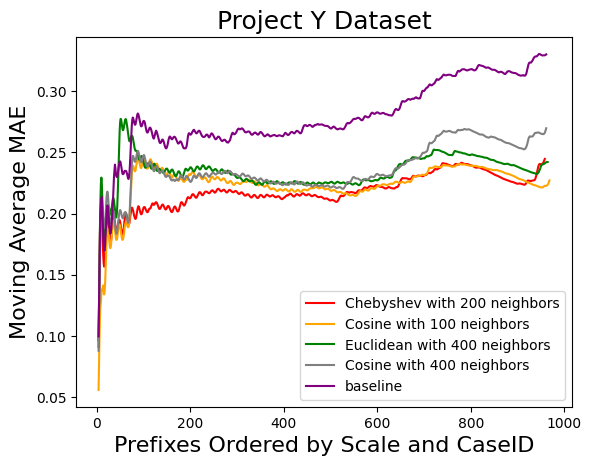

In [132]:

results_folder = 'results/CSL312'  # Replace with the path to your results folder

# Get the list of files in the results folder
files = os.scandir(results_folder)
# Get scandir object
with os.scandir(results_folder) as entries:
    # Extract file names
    file_names = [entry.name for entry in entries if entry.is_file() & entry.name.endswith('.csv')]

# Create a figure to display all the plots
# fig, ax = plt.subplots()
plt.figure()

# Loop through each file
for file in top_4_files:
    df = pd.read_csv(results_folder+"/"+file)
    # df = df.tail(963)
    df = df.sort_values([case_id_col, timestamp_col], ascending=[False, True]) 
    
    # Plot the moving average MAE
    # Calculate the moving average
    window_size = 5
    moving_avg = calculate_moving_avg_mae(df, target_col, 'predicted_value')
    
    # Plot the original values and the moving average
    label = filename_to_label.get(file, file)  # Get the custom label or default to filename
    if label == 'Chebyshev with 200 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='red')
    elif label == "Euclidean with 400 neighbors":
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='green')
    elif label == "Cosine with 100 neighbors":
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='orange')
    elif label == "Cosine with 400 neighbors":
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='gray')
    else:
        plt.plot(moving_avg['moving_avg_mae'], label=label)
    plt.legend(fontsize='small')
  

    # Set the labels and title for the plot
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Moving Average MAE')
    # ax.set_title('Moving Average MAE for Each File')
    # ax.legend()

    # Display the plot
baseline_results = baseline_results.sort_values([case_id_col,work_day_col], ascending=[False, True]) #
moving_avg_baseline = calculate_moving_avg_mae(baseline_results, target_col, 'predicted_value', window_size=5)
plt.plot(moving_avg_baseline['moving_avg_mae'], label='baseline', color='purple')
plt.legend(fontsize='medium')

# Set labels
plt.xlabel("Prefixes Ordered by Scale and CaseID", fontsize=16)
plt.ylabel("Moving Average MAE", fontsize=16)
plt.title("Project Y Dataset", fontsize=18)
plt.show()

# Save the figure in high quality
# plt.savefig('CSL312.png', dpi=400)
# plt.savefig('CSL312.pdf', format='pdf')


In [149]:
tmp = pd.read_csv('results/CSL312/CSL312_Catboost_no_encoding_no_bucketing_200_chebyshev.csv')

In [150]:
# Calculate metrics
true_values = tmp['Target']
predicted_values = tmp['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

MAE: 0.19797913462287894
MSE: 0.14697351797588734
RMSE: 0.3833712534552993
R2: 0.8618843310519901
MAPE: 0.7513473233821024


In [183]:
def calculate_reduction_percentage(original_number, reduced_number):
    reduction = original_number - reduced_number
    reduction_percentage = (reduction / original_number) * 100
    return reduction_percentage

# Example usage
original_number =  0.546
reduced_number = 0.340
percentage_reduction = calculate_reduction_percentage(original_number, reduced_number)
print(f"The reduction percentage is: {percentage_reduction}%")


The reduction percentage is: 37.72893772893773%


In [151]:
work_day_col

'Working Day (d)'

In [184]:
features

['BR Temp (°C)',
 'pH (Internal)',
 'Viability (%)',
 'VCD (10^6 cells/mL)',
 'Glutamine (g/L)',
 'Glutamate (g/L)',
 'Glucose (g/L)',
 'Lactate (g/L)',
 'NH4+ (g/L)',
 'Na+ (g/L)',
 'K+ (g/L)',
 'Ca2+ (g/L)']

In [180]:
work_day_values = tmp[work_day_col].unique()
phases = ['lag', 'Exponential', 'plateau']
dat = pd.DataFrame(columns=['Working Day', 'MAE', 'MSE', 'RMSE'])
for phase in phases:
    if phase == 'lag':
        work_day_phase = work_day_values[:3]
    elif phase == 'Exponential':
        work_day_phase = work_day_values[3:6]
    else:
        work_day_phase = work_day_values[6:]
    work_day_data = tmp[tmp[work_day_col].isin(work_day_phase)]
    predicted_values = work_day_data['predicted_value']
    target_values = work_day_data['Target']
    
    mae = np.mean(np.abs(predicted_values - target_values))
    mse = np.mean((predicted_values - target_values) ** 2)
    rmse = np.sqrt(mse)
    
    new_row = pd.DataFrame({'Working Day': [phase], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    dat = pd.concat([dat, new_row], ignore_index=True)
    
    print(f"Phase: {phase}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print()


Phase: lag
MAE: 0.04262905098772308
MSE: 0.019559197723397995
RMSE: 0.13985420166515555

Phase: Exponential
MAE: 0.1124888964808057
MSE: 0.029920426969656033
RMSE: 0.17297522068104446

Phase: plateau
MAE: 0.29677469964804826
MSE: 0.24722845038435817
RMSE: 0.4972207260205051



In [181]:
dat

,Working Day,MAE,MSE,RMSE
0,lag,0.042629,0.019559,0.139854
1,Exponential,0.112489,0.029920,0.172975
2,plateau,0.296775,0.247228,0.497221


In [182]:
dat2

,Working Day,MAE,MSE,RMSE
0,lag,0.057859,0.036996,0.192344
1,Exponential,0.137666,0.042324,0.205728
2,plateau,0.354588,0.312806,0.559291


In [179]:
work_day_values = baseline_results[work_day_col].unique()
phases = ['lag', 'Exponential', 'plateau']
dat2 = pd.DataFrame(columns=['Working Day', 'MAE', 'MSE', 'RMSE'])
for phase in phases:
    if phase == 'lag':
        work_day_phase = work_day_values[:3]
    elif phase == 'Exponential':
        work_day_phase = work_day_values[3:6]
    else:
        work_day_phase = work_day_values[6:]
    work_day_data = baseline_results[baseline_results[work_day_col].isin(work_day_phase)]
    predicted_values = work_day_data['predicted_value']
    target_values = work_day_data['Target']
    
    mae = np.mean(np.abs(predicted_values - target_values))
    mse = np.mean((predicted_values - target_values) ** 2)
    rmse = np.sqrt(mse)
    
    new_row = pd.DataFrame({'Working Day': [phase], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    dat2 = pd.concat([dat2, new_row], ignore_index=True)
    
    print(f"Phase: {phase}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print()

Phase: lag
MAE: 0.05785912758984288
MSE: 0.03699622945747545
RMSE: 0.19234403930841074

Phase: Exponential
MAE: 0.13766571752899417
MSE: 0.04232409622143349
RMSE: 0.20572820959079358

Phase: plateau
MAE: 0.3545884139582685
MSE: 0.3128062360375886
RMSE: 0.559290833142819



In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/CSL312_{method}_{config}_200_results.csv', index=False)

In [ ]:
import importlib
import sys
import time

In [ ]:
min_prefix_length = 1
max_prefix_length = df_normalized[work_day_col].max()

In [ ]:
# Remove both EncoderFactory and AggregateTransformer from sys.modules
modules_to_remove = ['EncoderFactory', 'transformers.AggregateTransformer', 'DatasetManager', "dataset_confs"]
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

# Re-import the modules
import EncoderFactory
import transformers.AggregateTransformer
import DatasetManager
from DatasetManager import DatasetManager

# Reload the modules
importlib.reload(transformers.AggregateTransformer)
importlib.reload(EncoderFactory)
# importlib.reload(DatasetManager)

In [ ]:
dataset_manager = DatasetManager("CSL312")

In [ ]:
start_test_prefix_generation = time.time()
dt_prefixes = dataset_manager.generate_prefix_data(df_normalized, min_prefix_length, max_prefix_length)
test_prefix_generation_time = time.time() - start_test_prefix_generation

In [ ]:
dt_prefixes[target_col].isnull().sum()

In [ ]:
dt_prefixes

In [ ]:
encoder = EncoderFactory.get_encoder(method='agg', case_id_col=case_id_col, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=['Cluster'],
                dynamic_num_cols=features, target_cols=[target_col,'Titer (g/L) original'], work_day_col=work_day_col, fillna=True, max_events=None, activity_col=None, resource_col=None, timestamp_col=timestamp_col,
                scale_model=None)

In [ ]:
dt_transformed = encoder.transform(dt_prefixes)
dt_transformed.columns

In [ ]:
dt_transformed = dt_transformed.reset_index(drop=False, inplace=False)
dt_transformed[work_day_col] = dt_transformed[case_id_col].str.split('_').str[2]
dt_transformed[work_day_col] = dt_transformed[work_day_col].fillna(0)
dt_transformed[case_id_col] = dt_transformed[case_id_col].str.split('_').str[0] + '_' + dt_transformed[case_id_col].str.split('_').str[1]


In [ ]:

dt_transformed


In [ ]:
features_new = [col for col in dt_transformed.columns if col not in ["Cluster", "'Titer (g/L) original'", case_id_col, target_col, work_day_col]]

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = dt_prefixes.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
# data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

# Initialize the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=200)
# Fit the model on the historic data
nn_model.fit(historic[features_used])

for index, row in current.iterrows():
    # Find the n nearest neighbors for the selected row
    distances, indices = nn_model.kneighbors([row[features_used]])
    nearest_neighbors = historic.iloc[indices[0]]

    target = nearest_neighbors['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

    # Add the current row with its prediction to the historic data
    row_with_prediction = row.copy()
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, pd.DataFrame([row_with_prediction])], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model.fit(historic[features_used])  # Refit the model with the updated historic data


In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/CSL312_{method}_{config}_results.csv', index=False)

In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df

#################################################################################################

In [ ]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill().bfill()

historic, current = split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/CSL312_baseline_{method}_{config}_results.csv', index=False)

In [ ]:
results_df_400 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_cosine_results.csv')
results_df_300 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_chebyshev_results.csv')
results_df_200 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_200_results.csv')
results_df_100 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_DTW_results.csv')

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_400['row_data'])

# Drop the original row_data column from results_df_baseline
tmp = results_df_400.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp = pd.concat([tmp, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp = tmp[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_300['row_data'])

# Drop the original row_data column from results_df_baseline
tmp2 = results_df_300.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp2 = pd.concat([tmp2, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp2 = tmp2[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_200['row_data'])

# Drop the original row_data column from results_df_baseline
tmp3 = results_df_200.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp3 = pd.concat([tmp3, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp3 = tmp3[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_100['row_data'])

# Drop the original row_data column from results_df_baseline
tmp4 = results_df_100.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp4 = pd.concat([tmp4, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp4 = tmp4[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

# Calculate moving average MAE for tmp
mae_df_tmp = calculate_moving_avg_mae(tmp, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp2 = calculate_moving_avg_mae(tmp2, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp3 = calculate_moving_avg_mae(tmp3, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp4 = calculate_moving_avg_mae(tmp4, 'true_value', 'predicted_value')

# Plot the moving average MAE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='cosine', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='levenshtein', color='red')
plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='euclidean', color='green')
plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='DTW', color='black')
plt.xlabel('Number of Observed Rows')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average MAE')
plt.title('CSL312')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
df_results = pd.DataFrame(results).T
# HMM regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()